In [1]:
import numpy as np
from scipy.spatial.distance import cdist
from scipy.spatial import distance
from scipy.stats import pearsonr
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import gensim
import os
import re
import seaborn as sns
import pandas as pd
pd.set_option('display.max_colwidth', -1)
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
import plotly
from plotly.subplots import make_subplots
import plotly.graph_objects as go
plotly.offline.init_notebook_mode()
import matplotlib.pyplot as plt
import matplotlib
import colorsys
import sys
import json
sys.path.append('..')
from mtc.mtc_config import NLP_MODELS_PATH, NLP_RAW_DATA, NLP_EXPERIMENT_PATH
from pathlib import Path

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/j562r/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to /home/j562r/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [2]:
# If problems with the fonts occur (e.g. it cannot find the serif family), run
# sudo apt-get install msttcorefonts -qq
# rm ~/.cache/matplotlib/fontlist-v*.json
# Source: https://stackoverflow.com/a/42841531
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = ['Times New Roman']
plt.rcParams['font.cursive'] = ['Times New Roman']
plt.rcParams['mathtext.fontset'] = 'custom'
plt.rcParams['mathtext.rm'] = 'Times New Roman'
plt.rcParams['mathtext.it'] = 'Times New Roman:italic'
plt.rcParams['mathtext.bf'] = 'Times New Roman:bold'
plt.rcParams['font.size'] = 18

## Load the Data

In [3]:
# Pure data
raw_train_path = NLP_RAW_DATA + '/n2c2/clinicalSTS2019.train.txt'
raw_test_path = NLP_RAW_DATA + '/n2c2/clinicalSTS2019.test.txt'
raw_test_path_labels = NLP_RAW_DATA + '/n2c2/clinicalSTS2019.test.gs.sim.txt'
df_train = pd.read_csv(raw_train_path, sep='\t', header=None, names=['a', 'b','Label'])

df_test = pd.read_csv(raw_test_path, sep='\t', header=None, names=['a', 'b'])
df_test['Label'] = pd.read_csv(raw_test_path_labels, sep='\t', header=None, names=['Label'])['Label']


# Results:
SET_DIR = NLP_EXPERIMENT_PATH + '/submission_generation/03_12_2020_20_18_37_original_data/bert_base/'
TSNE_DIR = SET_DIR + '1_example_run_step1/preprocessed_data_2020-03-15_21-49-55/'
vectors = np.load(TSNE_DIR + 'tsne_vectors.npy')
projections = np.load(TSNE_DIR + 'tsne_projections.npy')
#df_se = pd.read_pickle(os.path.join(NETWORK_SHARE + SET_DIR + '1_example_run_step1/preprocessed_data_2020-03-15_21-49-55/sentence_embeddings.pickle'))

test_train_labels = 2 * (1642 * ['Training set'] + 412 * ['Test set']) 
train_idx_bool = np.array([t == 'Training set' for t in test_train_labels])

The statistics show the absolute difference between the ground truth and the bert scores. Opaque points perform badly with bert.

## Sentence lengths test-train

In [4]:
def number_of_words(row):
    all_length = []
    number_of_words = (row['a'] + ' ' + row['b']).split()
    all_length.append(number_of_words)
    return len(number_of_words)
df_test['Number of Words'] = df_test.apply(lambda row: number_of_words(row), axis=1)
df_train['Number of Words'] = df_train.apply(lambda row: number_of_words(row), axis=1)

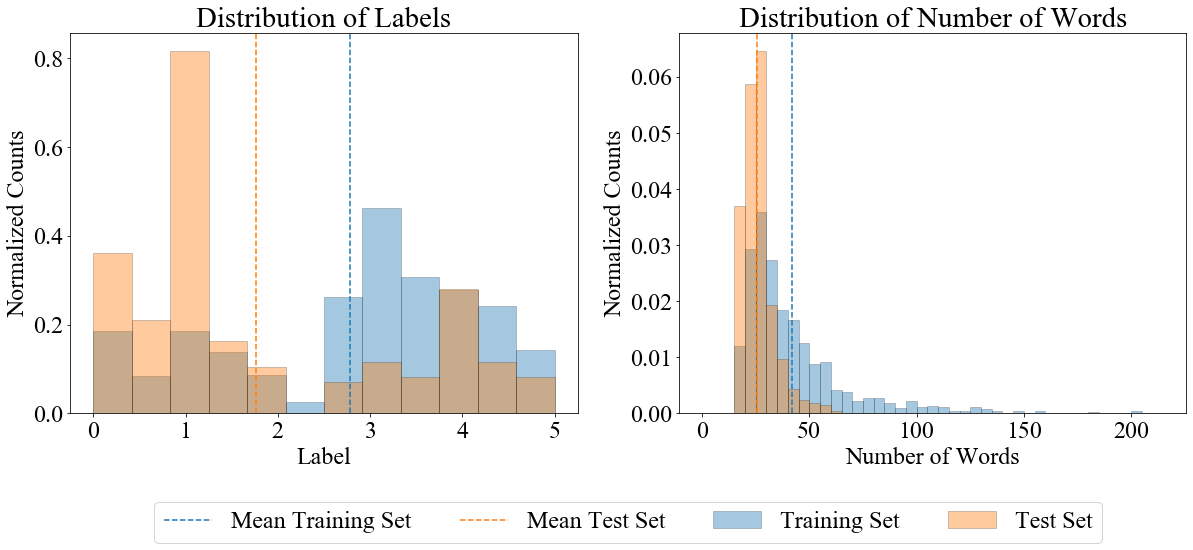

In [5]:
plt.rcParams['font.size'] = 24

fig, axes = plt.subplots(1, 2, figsize=(20, 7))
# sns.scatterplot(x="pca_x", y="pca_y", hue="label_name", palette=sns.color_palette("hls", df_dataset['labels'].nunique()),
#     data=df_dataset, legend="brief", alpha=0.8, ax=axes[0])
# sns.scatterplot(x="pca_x", y="pca_y", hue="pred_name", palette=sns.color_palette("hls", df_dataset['labels'].nunique()),
#     data=df_dataset, legend="brief", alpha=0.8, ax=axes[1])


hist_kws = {'edgecolor': "k", 'linewidth': 0.5}
sns.distplot(df_train['Label'], bins=12, kde=False, norm_hist=True, label='Training Set', ax=axes[0], color='#1f77b4', hist_kws=hist_kws)
sns.distplot(df_test['Label'], bins=12, kde=False, norm_hist=True, label='Test Set', ax=axes[0], color='#ff7f0e', hist_kws=hist_kws)

axes[0].set_ylabel('Normalized Counts')

axes[0].axvline(df_train['Label'].mean(), label='Mean Training Set', color='#1f77b4', linestyle='--')
#axes[0].axvline(df_train['Label'].mean()-np.std(df_train['Label']), label='Variance', color='r', linestyle=':')
#axes[0].axvline(df_train['Label'].mean()+np.std(df_train['Label']), color='r', linestyle=':')
axes[0].axvline(df_test['Label'].mean(), label='Mean Test Set', color='#ff7f0e', linestyle='--')
#axes[0].axvline(df_test['Label'].mean()-np.std(df_test['Label']), label='Variance', color='b', linestyle=':')
#axes[0].axvline(df_test['Label'].mean()+np.std(df_test['Label']), color='b', linestyle=':')
#axes[0].legend()
axes[0].set_title('Distribution of Labels')

sns.distplot(df_train['Number of Words'], bins=range(0, 220, 5), kde=False, norm_hist=True, label='Training Set', ax=axes[1], color='#1f77b4', hist_kws=hist_kws)
sns.distplot(df_test['Number of Words'], bins=range(0, 220, 5), kde=False, norm_hist=True, label='Test Set', ax=axes[1], color='#ff7f0e', hist_kws=hist_kws)
axes[1].axvline(df_train['Number of Words'].mean(), label='Mean Training Set', color='#1f77b4', linestyle='--')
#axes[1].axvline(df_train['Number of words'].mean()-np.std(df_train['Number of words']), label='Variance', color='r', linestyle=':')
#axes[1].axvline(df_train['Number of words'].mean()+np.std(df_train['Number of words']), color='r', linestyle=':')
axes[1].axvline(df_test['Number of Words'].mean(), label='Mean Test Set', color='#ff7f0e', linestyle='--')
#axes[1].axvline(df_test['Number of words'].mean()-np.std(df_test['Number of words']), label='Variance', color='b', linestyle=':')
#axes[1].axvline(df_test['Number of words'].mean()+np.std(df_test['Number of words']), color='b', linestyle=':')
#axes[1].legend(loc='upper center', bbox_to_anchor=(0.5, -0.05), ncol=4)
#ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05)
#          fancybox=True, shadow=True, ncol=5)

axes[1].set_ylabel('Normalized Counts')
axes[1].set_title('Distribution of Number of Words')
#f.title('distriution of labels and number of words in the training and test set.') 

handles, labels = axes[0].get_legend_handles_labels()
lgd = axes[1].legend(handles, labels, loc='upper center',  bbox_to_anchor=(-0.1, -0.2), ncol=4)
#fig.savefig(f"dataset_imbalance.png")
fig.savefig('dataset_imbalance.png', bbox_extra_artists=(lgd,), bbox_inches='tight')


In [6]:
pal = sns.color_palette(n_colors=2)
pal.as_hex()

['#1f77b4', '#ff7f0e']

In [7]:
df_train['Label'].mean(), df_test['Label'].mean()

(2.787484774665043, 1.7645631067961165)

In [8]:
df_train['Number of Words'].mean(), df_test['Number of Words'].mean()

(41.942143727162, 25.74271844660194)

# Sentence embeddings

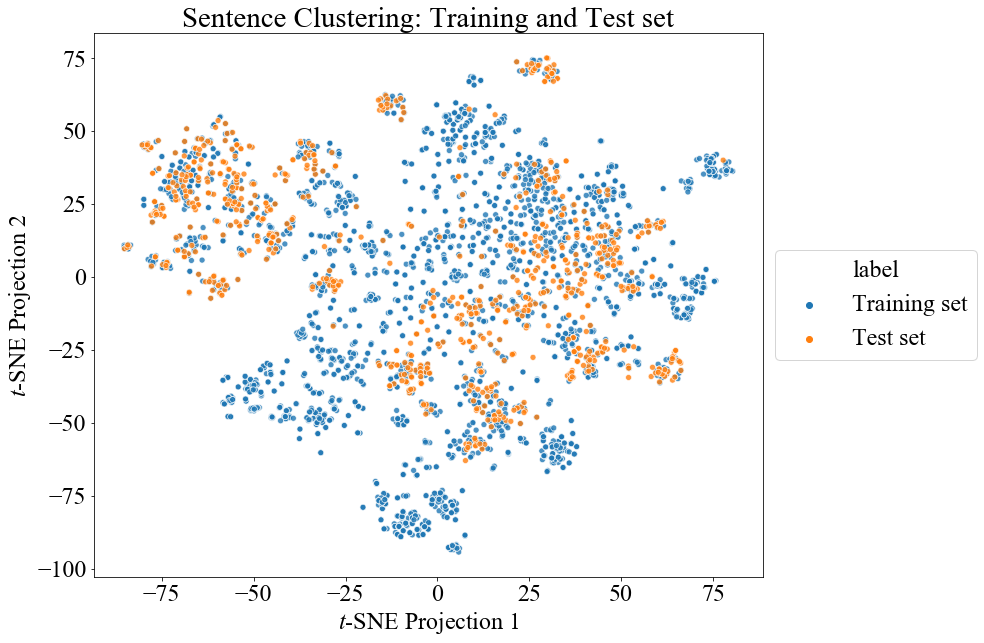

In [9]:
df_embeddings = pd.DataFrame({'$t$-SNE Projection 1': projections[:, 0], '$t$-SNE Projection 2': projections[:, 1], 'label': test_train_labels })
fig, ax = plt.subplots(figsize=(12, 10))
sns.scatterplot(x="$t$-SNE Projection 1", y="$t$-SNE Projection 2", hue=r'label', palette=sns.color_palette(n_colors=2),
    data=df_embeddings.sort_values('label', ascending=False), legend="brief", alpha=0.8, sizes=(20, 200)).set_title('Sentence Clustering: Training and Test set')
handles, labels = ax.get_legend_handles_labels()
#ax.legend(handles=handles[1:], labels=labels[1:], prop={'size': 15})
#lgd = ax.legend(handles, labels, loc='upper center',  bbox_to_anchor=(0.5, -0.2), ncol=3)
lgd = ax.legend(handles, labels, loc='center left', bbox_to_anchor=(1, 0.5))
#fig.savefig('clusterplot.png', bbox_extra_artists=(lgd,), bbox_inches='tight')

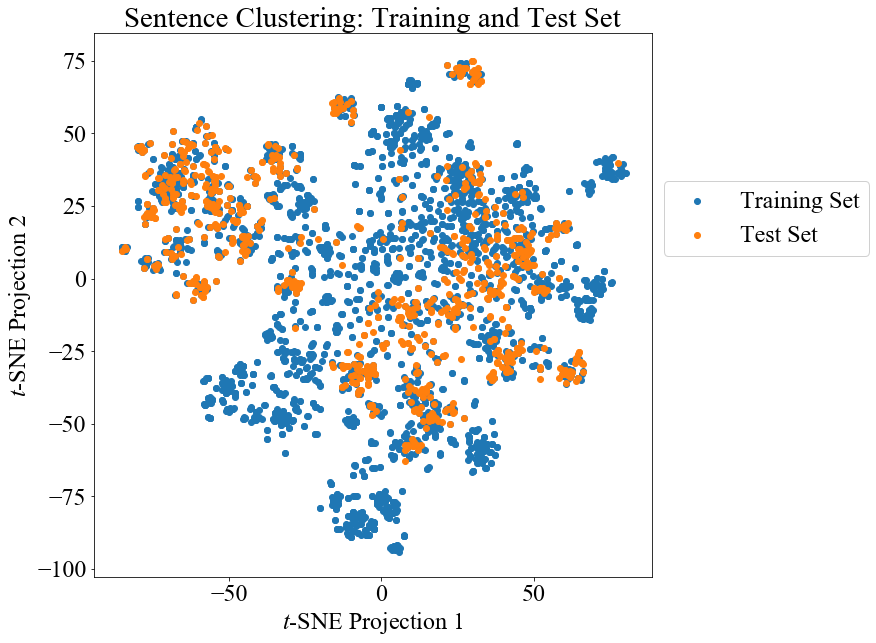

In [21]:
plt.rcParams['font.size'] = 24
fig, ax = plt.subplots(1, 1, figsize=(10, 10))

ax.scatter(projections[:, 0][train_idx_bool], projections[:, 1][train_idx_bool], c='#1f77b4', label='Training Set')
ax.scatter(projections[:, 0][~train_idx_bool], projections[:, 1][~train_idx_bool], c='#ff7f0e', label='Test Set')

ax.set_title('Sentence Clustering: Training and Test Set')
ax.set_xlabel('$t$-SNE Projection 1')
ax.set_ylabel('$t$-SNE Projection 2')
leg = ax.legend(framealpha=0.9, bbox_to_anchor=(1, 0.75))

# Remove opacity from legend marker points
for lh in leg.legendHandles:
    lh.set_alpha(1)

fig.savefig('clusterplot.png', bbox_inches='tight')

# Clustering

### Clustering only for train embeddings

In [11]:
train_bert_scores =  pd.read_csv(SET_DIR + '2_evaluate_bert_test/train_scores.csv', header=None)[0].tolist()
train_labelsx2 = np.array(df_train['Label'].tolist() + df_train['Label'].tolist())
train_bert_scoresx2 = np.array(train_bert_scores + train_bert_scores)
train_projections = projections[train_idx_bool]

In [12]:
pearsonr(df_train['Label'].tolist(), train_bert_scores)

(0.8499682968488111, 0.0)

In [13]:
k = 10
kmeans = KMeans(n_clusters=k, random_state=1337).fit( vectors[train_idx_bool])

In [14]:
df_train_embeddings= pd.DataFrame({'$t$-SNE Projection 1': train_projections[:, 0], '$t$-SNE Projection 2': train_projections[:, 1], 'label': kmeans.labels_, 'label_mu_sigma': kmeans.labels_, 'Bert scoers': train_bert_scoresx2, r'$\bf{Score}$ $\bf{Difference}$': abs(train_labelsx2-train_bert_scoresx2)})

In [15]:
cluster_labels = {}
for label in kmeans.labels_:
    scores_label = train_labelsx2[kmeans.labels_ == label]
    bscores_label = train_bert_scoresx2[kmeans.labels_ == label]
    score_diff = np.abs(scores_label - bscores_label)
    
    cluster_labels.update({label: 'Cluster {} (μ={:.2f}, σ={:.2f})'.format(label, np.mean(score_diff), np.std(score_diff))})

df_train_embeddings[r'$\bf{Sentence}$ $\bf{Cluster}$'] = [cluster_labels[label] for label in df_train_embeddings['label']]

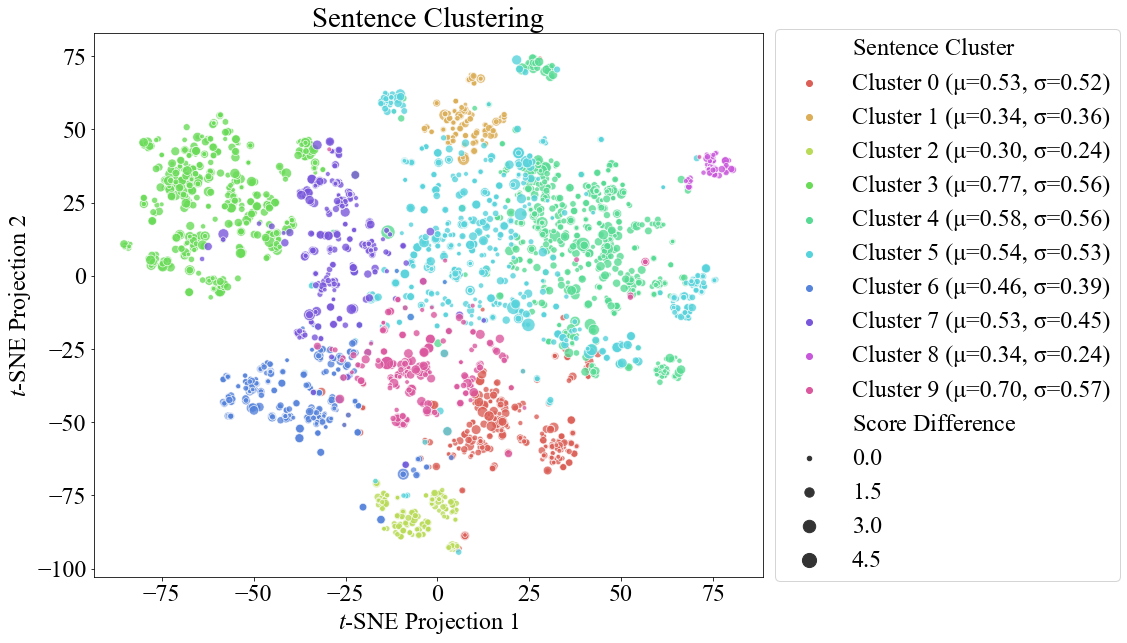

In [16]:
fig, ax = plt.subplots(figsize=(12, 10))
sns.scatterplot(x="$t$-SNE Projection 1", y="$t$-SNE Projection 2", hue=r'$\bf{Sentence}$ $\bf{Cluster}$', size=r'$\bf{Score}$ $\bf{Difference}$', palette=sns.color_palette("hls", df_train_embeddings['label'].nunique()),
    data=df_train_embeddings.sort_values('label', ascending=True), legend="brief", alpha=0.8, sizes=(20, 200)).set_title('Sentence Clustering')
handles, labels = ax.get_legend_handles_labels()
#ax.legend(handles=handles[1:], labels=labels[1:], prop={'size': 15})
#lgd = ax.legend(handles, labels, loc='upper center',  bbox_to_anchor=(0.5, -0.2), ncol=3)
lgd = ax.legend(handles, labels, loc='center left', bbox_to_anchor=(1, 0.5))
fig.savefig('clusterplot.png', bbox_extra_artists=(lgd,), bbox_inches='tight')

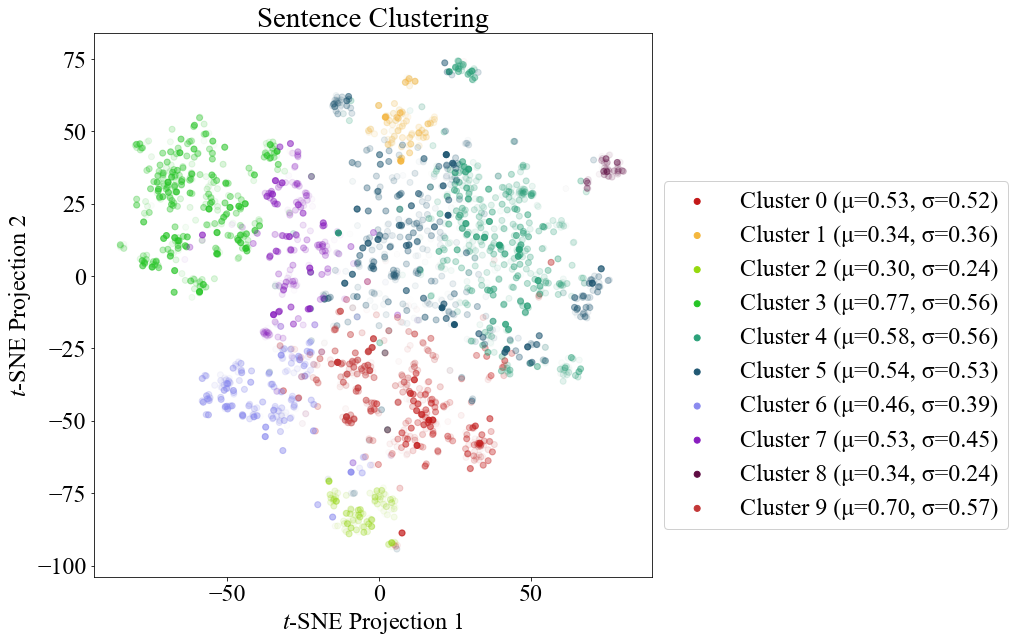

In [22]:
plt.rcParams['font.size'] = 24
fig, ax = plt.subplots(1, 1, figsize=(10, 10))

# Cluster colors
np.random.seed(1337)
cluster_colors = []
cluster_bg_colors = []
cluster_colors_values = []

for label in np.unique(kmeans.labels_):
    # Genertate a random distinct colour for the current cluster (as HLS)
    # Hue: equally distributed
    # Luminance: randomly generated without using extreme values
    # Saturation: randomly generated in the upper area (more saturated colours)
    color = [label / (k - 1), np.random.randint(20, 80) / 100, np.random.randint(50, 90) / 100]
    color = colorsys.hls_to_rgb(*color)
    
    # Use the gray value of the colour to decide whether a white or black background should be used
    # Conversion formula: https://en.wikipedia.org/wiki/Grayscale#Converting_color_to_grayscale
    gray_value = 0.2126*color[0] + 0.7152*color[1] + 0.0722*color[2]
    if gray_value < 0.5:
        cluster_bg_colors.append('rgba(255, 255, 255, 0.9)')
    else:
        cluster_bg_colors.append('rgba(0, 0, 0, 0.9)')
    
    # Convert the colour to a valid HTML specification
    color = [int(round(v * 255)) for v in color]
    cluster_colors_values.append(color)
    cluster_colors.append('rgb(' + ', '.join([str(c) for c in color]) + ')')

score_diffs = np.abs(scores_label - bscores_label)
score_diffs_min = np.min(score_diffs)
score_diffs_max = np.max(score_diffs)

for label, color in zip(np.unique(kmeans.labels_), cluster_colors_values):
    data_label = train_projections[kmeans.labels_ == label, :]
    scores_label = train_labelsx2[kmeans.labels_ == label]
    bscores_label = train_bert_scoresx2[kmeans.labels_ == label]
    
    # Normalized difference between BERT and the ground truth
    score_diff = np.abs(scores_label - bscores_label)
    opacity = (score_diff - score_diffs_min) / (score_diffs_max - score_diffs_min)
    opacity = np.clip(opacity, 0, 1)
    
    # Array with colors for each point in each row
    colors = np.zeros((data_label.shape[0], 4))
    colors[:, :3] = np.array(color) / 255
    colors[:, 3] = opacity
    
    label = f'Cluster {label} (μ={np.mean(score_diff):.2f}, σ={np.std(score_diff):.2f})'
    ax.scatter(data_label[:, 0], data_label[:, 1], c=colors, label=label)

ax.set_title('Sentence Clustering')
ax.set_xlabel('$t$-SNE Projection 1')
ax.set_ylabel('$t$-SNE Projection 2')
leg = ax.legend(framealpha=0.9, bbox_to_anchor=(1, 0.75))

# Remove opacity from legend marker points
for lh in leg.legendHandles:
    lh.set_alpha(1)

fig.savefig('clusterplot_bert_difference.png', bbox_inches='tight')

- Clusters not present in test set: 1, 2, 5, 6, 8
- Clusters present in test set: 0, 3, 4, 7, 9
- Cluster 3 and 7: Medication sentences
- Cluster 2 and 6: Long sentences



In [18]:
cluster_idx = df_train_embeddings[df_train_embeddings['label'] == 5].index.tolist()[0:50]
df_train.loc[cluster_idx]

a  \
0     Patient arrives, via hospital wheelchair, Gait steady, History obtained from patient, Patient appears comfortable, Patient cooperative, alert, Oriented to person, place and time.                                         
13   The remainder of a complete comprehensive multi-system review of systems is negative except as above.                                                                                                                       
17    Educational literature, developmentally age appropriate, provided at today's visit, including Caring for Your Three- to Five-Year-Old [].                                                                                  
20   I have reviewed the history, physical examination, impression, report, and plan with the team in detail and agree with the documentation outlined in their notes from today.                                                
29   Patient arrives, via hospital wheelchair, History obtained from patient, Patient appears, in distress due to pain, Patient cooperative, alert, Oriented to person, place and time.                                          
33   The patient will meet individually with the group provider nearing completion of LEARN and prior to bariatric surgery.                                                                                                      
36   When visiting a restaurant, the patient typically does add salt to the meal.                                                                                                                                                
44    Procedural pause conducted prior to each stage of procedure to verify: correct patient identity, procedure to be performed and as applicable, correct side and site, special equipment or special requirements.            
46   We recommend that the patient remain abstinent from all mood-altering drugs including alcohol for the time period as specified:                                                                                             
55    Patient arrives ambulatory, Gait steady, History obtained from patient, Patient appears, uncomfortable, Patient cooperative, alert, Oriented to person, place and time.                                                    
71    If the patient experiences any of these possible signs and symptoms of a DVT or PE, report to the local emergency room immediately.                                                                                        
74   The patient's test results were reviewed by the health care team and the patient was informed of the results via telephone.                                                                                                 
77   No: appendix removal; gallbladder removal; prior hysterectomy (removal of the uterus or womb); removal of both ovaries or tubal ligation or sterilization                                                                   
78    Complex assessment performed, Patient arrives ambulatory, Gait steady, History obtained from patient, Patient appears, uncomfortable, Patient cooperative, alert, Oriented to person, place and time.                      
81    Patient arrives, via stretcher, via Emergency Medical Services, Unsteady gait, Lift to cart, History obtained from patient, Patient appears comfortable, Patient cooperative, alert, Oriented to person, place and time.   
84   MEDICAL NECESSITY: The patient would benefit from skilled physical therapy interventions to be able to return the patient to full sporting activities.                                                                      
87    Reviewed with the patient the findings from the breast pathology and specifically, difference between in situ and invasive carcinomas.                                                                                     
94   Patient education materials provided: Home exercise program was provided with duration and frequency of exercises included.                         

In [19]:
sum(kmeans.labels_[:1642] == kmeans.labels_[1642:]) # Check for how many sentence pairs both sentences end up in the same cluster

1278

In [20]:
df_train[np.load(os.path.join(TSNE_DIR, 'test_cluster_idx.npy'))]

FileNotFoundError: [Errno 2] No such file or directory: '/home/j562r/nlp/output/submission_generation/03_12_2020_20_18_37_original_data/bert_base/1_example_run_step1/preprocessed_data_2020-03-15_21-49-55/test_cluster_idx.npy'

## $M$-Heads Analysis

In [ ]:
heads_folds = Path(NLP_EXPERIMENT_PATH) / 'submission_generation/04_27_2020_16_53_55_heads_output/heads/2_run/preprocessed_data_2020-04-27_16-56-22_biobert_pretrain_output_all_notes_150000'

all_pred_heads = []
all_pred_means = []

for k in range(150):
    with open(heads_folds / f'kfold{k}' / 'eval_results_dev_9.json', 'r') as file:
        train_result = json.load(file)
    
    for preds in train_result['pred_heads']:
        all_pred_heads += preds
    
    all_pred_means += train_result['pred']

In [ ]:
head_assignments = np.abs(np.array(all_pred_heads) - np.array(df_train['Label'].tolist()).reshape(-1, 1))
head_assignments = np.argmin(head_assignments, axis=1)
head_assignments = head_assignments.tolist()
df_train_embeddings['head_assignment'] = head_assignments + head_assignments

In [ ]:
fig, ax = plt.subplots(figsize=(12, 10))
sns.scatterplot(x="$t$-SNE Projection 1", y="$t$-SNE Projection 2", hue=r'head_assignment',
    data=df_train_embeddings.sort_values('label', ascending=True), legend="brief", alpha=0.8, s=80).set_title('Sentence Clustering')
handles, labels = ax.get_legend_handles_labels()
#ax.legend(handles=handles[1:], labels=labels[1:], prop={'size': 15})
#lgd = ax.legend(handles, labels, loc='upper center',  bbox_to_anchor=(0.5, -0.2), ncol=3)
lgd = ax.legend(handles, labels, loc='center left', bbox_to_anchor=(1, 0.5))

In [ ]:
np.unique(head_assignments, return_counts=True)